In [12]:
import pandas as pd
import pathlib

%matplotlib inline
import keras
import os
os.environ["SM_FRAMEWORK"] = "keras"
import segmentation_models as sm
from segmentation_models import Unet
from keras.layers import Input, Conv2D
from keras.models import Model





In [4]:
import os

# im_path_tr = '/content/drive/MyDrive/EE581/Data/TrainData/img/'
# ma_path_tr = "/content/drive/MyDrive/EE581/Data/TrainData/mask"

im_path_tr = pathlib.Path('..') / '..' / 'data' / 'Landslide4Sense_Original' / 'TrainData' / 'img'
ma_path_tr = pathlib.Path('..') / '..' / 'data' / 'Landslide4Sense_Original' / 'TrainData' / 'mask'



# im_path_te = "Data/TestData/img"
# ma_path_te = "Data/TestData/img"

# im_path_va = "Data/ValidData/img"
# ma_path_va = "Data/ValidData/img"

print(os.path.isdir(im_path_tr))
print(os.path.isfile(im_path_tr/'image_1.h5'))

True
True


In [5]:
# Testing the dataset

path_single = im_path_tr / "image_1.h5"
path_single_mask = ma_path_tr / 'mask_1.h5'

Available keys in the HDF5 file: ['img']
Input data shape: (128, 128, 14)


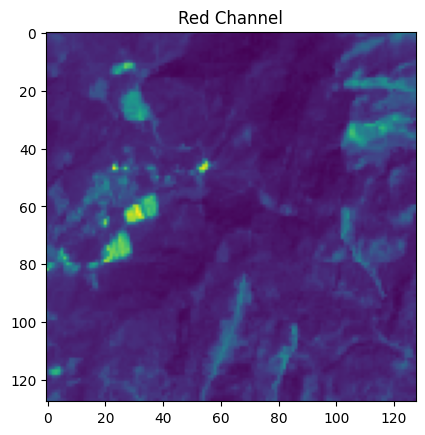

data_ndvi shape: (128, 128) f_data shape: (1, 128, 128, 3)


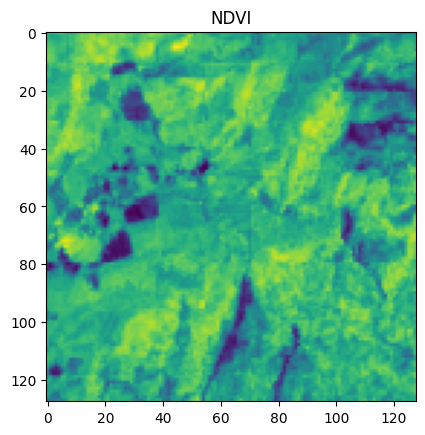

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# File paths (ensure these are correct for Kaggle)
path_single = im_path_tr/"image_1.h5"
path_single_mask = ma_path_tr/'mask_1.h5'

f_data = np.zeros((1, 128, 128, 3))

# Open the HDF5 file
with h5py.File(path_single, 'r') as hdf:
    # Print keys in the HDF5 file
    ls = list(hdf.keys())
    print("Available keys in the HDF5 file:", ls)

    # Check if 'img' key exists
    if 'img' not in ls:
        raise KeyError("'img' key not found in HDF5 file")

    # Load the image data
    data = np.array(hdf.get('img'))
    print("Input data shape:", data.shape)

    # Check the shape to avoid indexing errors
    if data.shape[2] < 14:
        raise ValueError("The data has fewer than 14 channels. Shape:", data.shape)

    # Display a sample image (e.g., Red channel)
    plt.imshow(data[:, :, 3])  # Red channel (adjust as needed)
    plt.title("Red Channel")
    plt.show()

    # Extract specific bands for NDVI calculation
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_swir = data[:, :, 10]

    # MSI = Band1600nm / Band820nm


    # Calculate NDVI (Normalized Difference Vegetation Index)
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red), where=(data_nir + data_red) != 0)

    # Store NDVI and other bands in f_data
    f_data[0, :, :, 0] = data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]
    print("data_ndvi shape:", data_ndvi.shape, "f_data shape:", f_data.shape)

    # Plot NDVI
    plt.imshow(data_ndvi, cmap='viridis')
    plt.title("NDVI")
    plt.show()

ls ['mask']
input data shape: (128, 128)


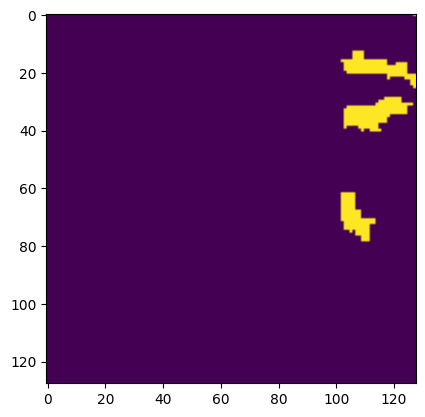

In [7]:
with h5py.File(path_single_mask) as hdf:

    ls = list(hdf.keys())

    print("ls", ls)

    data = np.array(hdf.get('mask'))

    print("input data shape:", data.shape)

    plt.imshow(data)

In [8]:

TRAIN_XX = np.zeros((3799, 128, 128, 11))

TRAIN_YY = np.zeros((3799, 128, 128, 1))

all_train = sorted(im_path_tr.glob('*'))

all_mask = sorted(ma_path_tr.glob('*'))


Train with RGB, NDVI, DEM, and Slop

In [9]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU Name: {gpu.name}")
else:
    print("No GPUs Available")


No GPUs Available


In [10]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):

    print(i, img, mask)

    with h5py.File(img) as hdf:

        ls = list(hdf.keys())

        data = np.array(hdf.get('img'))



        # assign 0 for the nan value

        data[np.isnan(data)] = 0.000001

        # to normalize the data

        mid_rgb = data[:, :, 1:4].max() / 2.0

        mid_4 = data[:, :, 4].max() / 2.0

        mid_5 = data[:, :, 5].max() / 2.0

        mid_6 = data[:, :, 6].max() / 2.0

        mid_7 = data[:, :, 7].max() / 2.0

        mid_8 = data[:, :, 8].max() / 2.0

        mid_slope = data[:, :, 12].max() / 2.0

        mid_elevation = data[:, :, 13].max() / 2.0

        # # ndvi calculation

        data_red = data[:, :, 3]

        data_nir = data[:, :, 7]

        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        # final array

        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED

        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN

        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE

        TRAIN_XX[i, :, :, 3] = 1 - data[:, :, 4]/ mid_5

        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 5]/ mid_5 #data_ndvi #NDVI

        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 6]/ mid_5

        TRAIN_XX[i, :, :, 6] = 1 - data[:, :, 7]/ mid_5

        TRAIN_XX[i, :, :, 7] = 1 - data[:, :, 8]/ mid_5

        TRAIN_XX[i, :, :, 8] = 1 - data[:, :, 12] / mid_slope #SLOPE

        TRAIN_XX[i, :, :, 9] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

        TRAIN_XX[i, :, :, 10] = data_ndvi #NDVI





    with h5py.File(mask) as hdf:

        ls = list(hdf.keys())

        data=np.array(hdf.get('mask'))

        TRAIN_YY[i, :, :, 0] = data

0 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_1.h5
1 ..\..\data\Landslide4Sense_Original\TrainData\img\image_10.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_10.h5
2 ..\..\data\Landslide4Sense_Original\TrainData\img\image_100.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_100.h5
3 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1000.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_1000.h5
4 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1001.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_1001.h5
5 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1002.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_1002.h5
6 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1003.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_1003.h5
7 ..\..\data\Landslide4Sense_Original\TrainData\img\image_1004.h5 ..\..\data\Landslide4Sense_Original\

C:\Users\cakef\AppData\Local\Temp\ipykernel_9640\3758775526.py:61: RuntimeWarning: invalid value encountered in divide
  TRAIN_XX[i, :, :, 8] = 1 - data[:, :, 12] / mid_slope #SLOPE


1678 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2509.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2509.h5
1679 ..\..\data\Landslide4Sense_Original\TrainData\img\image_251.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_251.h5
1680 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2510.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2510.h5
1681 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2511.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2511.h5
1682 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2512.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2512.h5
1683 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2513.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2513.h5
1684 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2514.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_2514.h5
1685 ..\..\data\Landslide4Sense_Original\TrainData\img\image_2515.h5 ..

C:\Users\cakef\AppData\Local\Temp\ipykernel_9640\3758775526.py:41: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


2264 ..\..\data\Landslide4Sense_Original\TrainData\img\image_3036.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_3036.h5
2265 ..\..\data\Landslide4Sense_Original\TrainData\img\image_3037.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_3037.h5
2266 ..\..\data\Landslide4Sense_Original\TrainData\img\image_3038.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_3038.h5
2267 ..\..\data\Landslide4Sense_Original\TrainData\img\image_3039.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_3039.h5
2268 ..\..\data\Landslide4Sense_Original\TrainData\img\image_304.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_304.h5
2269 ..\..\data\Landslide4Sense_Original\TrainData\img\image_3040.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_3040.h5
2270 ..\..\data\Landslide4Sense_Original\TrainData\img\image_3041.h5 ..\..\data\Landslide4Sense_Original\TrainData\mask\mask_3041.h5
2271 ..\..\data\Landslide4Sense_Original\TrainData\img\image_3042.h5 ..

In [ ]:
# for i, (img, mask) in enumerate(zip(all_train, all_mask)):

#     print(i, img, mask)

#     with h5py.File(img) as hdf:

#         ls = list(hdf.keys())

#         data = np.array(hdf.get('img'))



#         # assign 0 for the nan value

#         data[np.isnan(data)] = 0.000001



#         # to normalize the data

#         mid_rgb = data[:, :, 1:4].max() / 2.0

#         # mid_4 = data[:, :, 4].max() / 2.0

#         # mid_5 = data[:, :, 5].max() / 2.0

#         # mid_6 = data[:, :, 6].max() / 2.0

#         # mid_7 = data[:, :, 7].max() / 2.0

#         # mid_8 = data[:, :, 8].max() / 2.0

#         mid_slope = data[:, :, 12].max() / 2.0

#         mid_elevation = data[:, :, 13].max() / 2.0



#         # ndvi calculation

#         data_red = data[:, :, 3]

#         data_nir = data[:, :, 7]

#         data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))



#         # final array

#         TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED

#         TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN

#         TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE

#         TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI

#         TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE

#         TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION





#     with h5py.File(mask) as hdf:

#         ls = list(hdf.keys())

#         data=np.array(hdf.get('mask'))

#         TRAIN_YY[i, :, :, 0] = data



Testing min, max values in train data¶


In [ ]:

# TRAIN_XX_n = TRAIN_XX / TRAIN_XX.max()

TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001

print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-7.072144312350469 1.0 0.0 1.0


In [ ]:
def dice_loss(y_true, y_pred):

  y_true = tf.cast(y_true, tf.float32)

  y_pred = tf.math.sigmoid(y_pred)

  numerator = 2 * tf.reduce_sum(y_true * y_pred)

  denominator = tf.reduce_sum(y_true + y_pred)



  return 1 - numerator / denominator

### All Channels

In [ ]:
from sklearn.model_selection import train_test_split



# Split the data

x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX[:,:,:,0:10], TRAIN_YY, test_size=0.2, shuffle= True)

In [ ]:
import tensorflow as tf
import numpy as np

# Example dataset
batch_size = 32
# hyperspectral_images = np.random.rand(batch_size, 128, 128, 10).astype(np.float32)
# segmentation_masks = np.random.randint(0, 2, (batch_size, 128, 128, 1)).astype(np.float32)

# Convert to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

def random_flip(image, mask):
    """Randomly flip both image and mask."""
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    return image, mask

def random_rotate(image, mask):
    """Randomly rotate image and mask by 0, 90, 180, or 270 degrees."""
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)
    return image, mask

# def random_crop(image, mask):
#     """Randomly crop a 112x112 region from image and mask."""
#     stacked = tf.concat([image, mask], axis=-1)
#     cropped = tf.image.random_crop(stacked, size=[112, 112, image.shape[-1] + mask.shape[-1]])
#     return cropped[..., :-mask.shape[-1]], cropped[..., -mask.shape[-1]:]

def random_jitter(image, mask):
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float64)  # Ensure float32
    image = image + noise  # Now both tensors are float32
    return image, mask


def augment(image, mask):
    """Apply all augmentations to both image and mask."""
    image, mask = random_flip(image, mask)
    image, mask = random_rotate(image, mask)
    # image, mask = random_crop(image, mask)
    image, mask = random_jitter(image, mask)
    return image, mask

# Create augmented dataset
# Create augmented dataset
augmented_dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# # Concatenate original and augmented datasets
# doubled_dataset = dataset.concatenate(augmented_dataset)

# Concatenate original and augmented datasets to double the dataset size
train_dataset = dataset.concatenate(augmented_dataset)

# Batch and prefetch
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
x_train.shape, y_train.shape


((3039, 128, 128, 10), (3039, 128, 128, 1))

In [ ]:
# del TRAIN_XX

# del TRAIN_YY

# del all_train

# del all_mask

## UNET MODEL

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Custom Metrics
from keras import backend as K

def recall_m(y_true, y_pred):


    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:


# Define UNet Model
def unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    inputs = keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

    # Contracting Path
    c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = keras.layers.Dropout(0.1)(c1)
    c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = keras.layers.Dropout(0.1)(c2)
    c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = keras.layers.Dropout(0.2)(c3)
    c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = keras.layers.Dropout(0.2)(c4)
    c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = keras.layers.Dropout(0.3)(c5)
    c5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expanding Path
    u6 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = keras.layers.Dropout(0.2)(c6)
    c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = keras.layers.Dropout(0.2)(c7)
    c7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = keras.layers.Dropout(0.1)(c8)
    c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1])
    c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = keras.layers.Dropout(0.1)(c9)
    c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

    return model


In [ ]:
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr *0.25

In [ ]:
import gc
import tensorflow as tf

path = "/content/drive/MyDrive/EE581/"

def train(model, model_name, data, learning_rate, loss_type='binary_crossentropy'):

  loss_type_str = loss_type.__name__ if callable(loss_type) else loss_type
  model_name = model_name + '_' + str(learning_rate) + '_' + loss_type_str


  opt = keras.optimizers.AdamW(learning_rate=learning_rate)

  model.compile(optimizer=opt, loss=loss_type, metrics=['accuracy', f1_m, precision_m, recall_m])

  earlyStopping = keras.callbacks.EarlyStopping(
      monitor="val_f1_m", patience=5, verbose=1, mode="max"
  )

  lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_f1_m',    # Monitor validation loss
    factor=0.5,            # Reduce LR by multiplying with this factor
    patience=4,            # Number of epochs with no improvement before reducing LR
    min_lr=learning_rate/10,           # Lower bound on learning rate
    verbose=1              # Print message when LR is reduced
  )

  # Use scheudler (the argument) for conditional check
  callbacks = [earlyStopping, lr_scheduler]

  if isinstance(data, tuple):
    # Train the model
    history = model.fit(
        data[0],data[1], batch_size=16, epochs=60, verbose=1,
        validation_data=(x_valid, y_valid), callbacks=callbacks
    )
  else :
    # Train the model
    history = model.fit(
        data, batch_size=16, epochs=60, verbose=1,
        validation_data=(x_valid, y_valid), callbacks=callbacks
    )

  # Convert history to DataFrame and save as CSV
  df = pd.DataFrame(history.history)
  df.to_csv(path + model_name + '.csv', index=False)

  # Evaluate the model
  loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
  print(f"Loss: {loss}, Accuracy: {accuracy}, F1 Score: {f1_score}, Precision: {precision}, Recall: {recall}")

  # Delete the model
  del model
  gc.collect()

  # Clear backend
  keras.backend.clear_session()

In [ ]:
# list all models

IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 128, 128, 10


LRs = [1e-3, 1e-4, 1e-5]
LOSSs = ['binary_crossentropy', dice_loss]

for learning_rate in LRs:
  for loss_type in LOSSs:

    base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

    N = x_train.shape[-1]

    ## inceptionv3 imagenet
    model_name = "inceptionv3"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3_img = Model(inp, out, name=base_model.name)

    ## inceptionv3 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3 = Model(inp, out, name=base_model.name)

    ## resnet50 imagenet
    model_name = "resnet50"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50_img = Model(inp, out, name=base_model.name)

    ## resnet50 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50 = Model(inp, out, name=base_model.name)

    models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]
    model_names = ["base_unet","inceptionv3_img", "inceptionv3", "resnet50_img", "resnet50"]

    spec = "10Chan"

    for model, model_name in zip(models, model_names):

        print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
        train(model, model_name+spec, data = (x_train, y_train) , learning_rate = learning_rate, loss_type = loss_type)

##### AUG


LRs = [1e-3, 1e-4, 1e-5]
LOSSs = ['binary_crossentropy', dice_loss]

for learning_rate in LRs:
  for loss_type in LOSSs:

    base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

    N = x_train.shape[-1]

    ## inceptionv3 imagenet
    model_name = "inceptionv3"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3_img = Model(inp, out, name=base_model.name)

    ## inceptionv3 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3 = Model(inp, out, name=base_model.name)

    ## resnet50 imagenet
    model_name = "resnet50"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50_img = Model(inp, out, name=base_model.name)

    ## resnet50 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50 = Model(inp, out, name=base_model.name)

    models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]
    model_names = ["base_unet_aug","inceptionv3_img_aug", "inceptionv3_aug", "resnet50_img_aug", "resnet50"]

    spec = "10Chan"

    for model, model_name in zip(models, model_names):
      print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
      train(model, model_name+spec, data = train_dataset , learning_rate = learning_rate, loss_type = loss_type)



base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

N = x_train.shape[-1]

# inceptionv3 imagenet
model_name = "inceptionv3"

base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_inceptionv3_img = Model(inp, out, name=base_model.name)

## inceptionv3 random

base_model = Unet(backbone_name=model_name, encoder_weights=None)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_inceptionv3 = Model(inp, out, name=base_model.name)

## resnet50 imagenet
model_name = "resnet50"

base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_resnet50_img = Model(inp, out, name=base_model.name)

## resnet50 random

base_model = Unet(backbone_name=model_name, encoder_weights=None)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_resnet50 = Model(inp, out, name=base_model.name)

models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]
model_names = ["base_unet_aug","inceptionv3_img_aug", "inceptionv3_aug", "resnet50_img_aug", "resnet50"]

for model, model_name in zip(models, model_names):
  for learning_rate in LRs:
    for loss_type in LOSSs:
      for sheduler in [None, scheduler]:
        print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
        train(model, model_name+spec, data = train_dataset , learning_rate = learning_rate, loss_type = loss_type, scheudler = sheduler)



Training base_unet_aug10Chan with learning rate 0.001 and loss binary_crossentropy
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4868']
Received: inputs=Tensor(shape=(None, 128, 128, 10))
  warnings.warn(msg)


190/190 ━━━━━━━━━━━━━━━━━━━━ 39s 115ms/step - accuracy: 0.9486 - f1_m: 0.0520 - loss: 0.1362 - precision_m: 0.3014 - recall_m: 0.0648 - val_accuracy: 0.9843 - val_f1_m: 0.5650 - val_loss: 0.0399 - val_precision_m: 0.5951 - val_recall_m: 0.5651 - learning_rate: 0.0010
Epoch 2/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9832 - f1_m: 0.6264 - loss: 0.0439 - precision_m: 0.7106 - recall_m: 0.5789 - val_accuracy: 0.9871 - val_f1_m: 0.6052 - val_loss: 0.0334 - val_precision_m: 0.6788 - val_recall_m: 0.5627 - learning_rate: 0.0010
Epoch 3/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9847 - f1_m: 0.6479 - loss: 0.0404 - precision_m: 0.7497 - recall_m: 0.5824 - val_accuracy: 0.9880 - val_f1_m: 0.5967 - val_loss: 0.0320 - val_precision_m: 0.7437 - val_recall_m: 0.5127 - learning_rate: 0.0010
Epoch 4/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9855 - f1_m: 0.6651 - loss: 0.0375 - precision_m: 0.7720 - recall_m: 0.5935 - val_accuracy: 0.9882 - val_f1_m: 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 10))
  warnings.warn(msg)


190/190 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - accuracy: 0.8604 - f1_m: 0.2621 - loss: 0.9402 - precision_m: 0.1615 - recall_m: 0.8043 - val_accuracy: 0.9574 - val_f1_m: 0.4302 - val_loss: 0.9502 - val_precision_m: 0.2899 - val_recall_m: 0.8862 - learning_rate: 0.0010
Epoch 2/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9397 - f1_m: 0.4425 - loss: 0.9349 - precision_m: 0.2924 - recall_m: 0.9519 - val_accuracy: 0.9190 - val_f1_m: 0.3066 - val_loss: 0.9499 - val_precision_m: 0.1857 - val_recall_m: 0.9708 - learning_rate: 0.0010
Epoch 3/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9423 - f1_m: 0.4542 - loss: 0.9348 - precision_m: 0.3027 - recall_m: 0.9537 - val_accuracy: 0.9080 - val_f1_m: 0.2824 - val_loss: 0.9500 - val_precision_m: 0.1679 - val_recall_m: 0.9816 - learning_rate: 0.0010
Epoch 4/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9424 - f1_m: 0.4588 - loss: 0.9347 - precision_m: 0.3076 - recall_m: 0.9572 - val_accuracy: 0.9329 - val_f1_m: 0

RGB

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX[:,:,:,0:3], TRAIN_YY, test_size=0.2, shuffle= True)

In [ ]:

# uncomment for 

# batch_size = 32

# # Convert to TensorFlow Dataset
# dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# # Create augmented dataset
# augmented_dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# # Concatenate original and augmented datasets to double the dataset size
# train_dataset = dataset.concatenate(augmented_dataset)

# # Batch and prefetch
# train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
# x_train.shape, y_train.shape


((3039, 128, 128, 3), (3039, 128, 128, 1))

In [ ]:
# list all models

IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 128, 128, 3


LRs = [1e-3, 1e-4, 1e-5]
LOSSs = ['binary_crossentropy', dice_loss]

for learning_rate in LRs:
  for loss_type in LOSSs:

    base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

    N = x_train.shape[-1]

    ## inceptionv3 imagenet
    model_name = "inceptionv3"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3_img = Model(inp, out, name=base_model.name)

    ## inceptionv3 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3 = Model(inp, out, name=base_model.name)

    ## resnet50 imagenet
    model_name = "resnet50"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50_img = Model(inp, out, name=base_model.name)

    ## resnet50 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50 = Model(inp, out, name=base_model.name)

    models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]
    model_names = ["base_unet","inceptionv3_img", "inceptionv3", "resnet50_img", "resnet50"]

    spec = "RGB"

    for model, model_name in zip(models, model_names):
      print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
      train(model, model_name+spec, data = (x_train, y_train) , learning_rate = learning_rate, loss_type = loss_type)

##### AUG


LRs = [1e-3, 1e-4, 1e-5]
LOSSs = ['binary_crossentropy', dice_loss]

for learning_rate in LRs:
  for loss_type in LOSSs:

    base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

    N = x_train.shape[-1]

    ## inceptionv3 imagenet
    model_name = "inceptionv3"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3_img = Model(inp, out, name=base_model.name)

    ## inceptionv3 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3 = Model(inp, out, name=base_model.name)

    ## resnet50 imagenet
    model_name = "resnet50"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50_img = Model(inp, out, name=base_model.name)

    ## resnet50 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50 = Model(inp, out, name=base_model.name)

    models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]
    model_names = ["base_unet_aug","inceptionv3_img_aug", "inceptionv3_aug", "resnet50_img_aug", "resnet50"]

    spec = "RGB"

    for model, model_name in zip(models, model_names):

      print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
      train(model, model_name+spec, data = train_dataset , learning_rate = learning_rate, loss_type = loss_type)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training base_unetRGB with learning rate 0.001 and loss binary_crossentropy
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


190/190 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.9432 - f1_m: 0.0328 - loss: 0.1396 - precision_m: 0.2417 - recall_m: 0.0535 - val_accuracy: 0.9768 - val_f1_m: 0.0390 - val_loss: 0.0702 - val_precision_m: 0.5860 - val_recall_m: 0.0203 - learning_rate: 0.0010
Epoch 2/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9759 - f1_m: 0.0829 - loss: 0.0681 - precision_m: 0.6091 - recall_m: 0.0494 - val_accuracy: 0.9782 - val_f1_m: 0.2263 - val_loss: 0.0579 - val_precision_m: 0.6423 - val_recall_m: 0.1405 - learning_rate: 0.0010
Epoch 3/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9784 - f1_m: 0.2657 - loss: 0.0602 - precision_m: 0.6128 - recall_m: 0.1893 - val_accuracy: 0.9789 - val_f1_m: 0.3700 - val_loss: 0.0537 - val_precision_m: 0.5835 - val_recall_m: 0.2809 - learning_rate: 0.0010
Epoch 4/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9794 - f1_m: 0.3648 - loss: 0.0552 - precision_m: 0.6140 - recall_m: 0.2832 - val_accuracy: 0.9793 - val_f1_m: 0

In [ ]:
# list all models
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 128, 128, 3

base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

N = x_train.shape[-1]

## inceptionv3 imagenet
model_name = "inceptionv3"

model_inceptionv3_img = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

## inceptionv3 random

model_inceptionv3 = Unet(backbone_name=model_name, encoder_weights=None)

## resnet50 imagenet
model_name = "resnet50"

model_resnet50_img = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

## resnet50 random

model_resnet50 = Unet(backbone_name=model_name, encoder_weights=None)


models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]
model_names = ["base_unet","inceptionv3_img", "inceptionv3", "resnet50_img", "resnet50"]

LRs = [1e-3, 1e-4, 1e-5]
LOSSs = ['binary_crossentropy', dice_loss]

spec = "RGB"

for model, model_name in zip(models, model_names):
  for learning_rate in LRs:
    for loss_type in LOSSs:
      for sheduler in [None, scheduler]:
        print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
        train(model, model_name+spec, data = (x_train, y_train) , learning_rate = learning_rate, loss_type = loss_type, scheudler = sheduler)


base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

N = x_train.shape[-1]

## inceptionv3 imagenet
model_name = "inceptionv3"

model_inceptionv3_img = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

## inceptionv3 random

model_inceptionv3 = Unet(backbone_name=model_name, encoder_weights=None)

## resnet50 imagenet
model_name = "resnet50"

model_resnet50_img = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

## resnet50 random

model_resnet50 = Unet(backbone_name=model_name, encoder_weights=None)


models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]
model_names = ["base_unet_aug","inceptionv3_img_aug", "inceptionv3_aug", "resnet50_img_aug", "resnet50"]

for model, model_name in zip(models, model_names):
  for learning_rate in LRs:
    for loss_type in LOSSs:
      for sheduler in [None, scheduler]:
        print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
        train(model, model_name+spec, data = train_dataset , learning_rate = learning_rate, loss_type = loss_type, scheudler = sheduler)




6 Channels

In [ ]:
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 128, 128, 6

x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX[:, :, :, [0, 1, 2, 8, 9, 10]], TRAIN_YY, test_size=0.2, shuffle= True)

In [ ]:

batch_size = 32

# Convert to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Create augmented dataset
augmented_dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# Concatenate original and augmented datasets to double the dataset size
train_dataset = dataset.concatenate(augmented_dataset)

# Batch and prefetch
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
x_train.shape, y_train.shape


((3039, 128, 128, 6), (3039, 128, 128, 1))

In [ ]:
# list all models

IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 128, 128, 6


LRs = [1e-3, 1e-4, 1e-5]
LOSSs = ['binary_crossentropy', dice_loss]

for learning_rate in LRs:
  for loss_type in LOSSs:

    base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

    N = x_train.shape[-1]

    ## inceptionv3 imagenet
    model_name = "inceptionv3"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3_img = Model(inp, out, name=base_model.name)

    ## inceptionv3 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3 = Model(inp, out, name=base_model.name)

    ## resnet50 imagenet
    model_name = "resnet50"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50_img = Model(inp, out, name=base_model.name)

    ## resnet50 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50 = Model(inp, out, name=base_model.name)

    models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]
    model_names = ["base_unet","inceptionv3_img", "inceptionv3", "resnet50_img", "resnet50"]

    spec = "6Chan"

    for model, model_name in zip(models, model_names):

      print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
      train(model, model_name+spec, data = (x_train, y_train) , learning_rate = learning_rate, loss_type = loss_type)

##### AUG


LRs = [1e-3, 1e-4, 1e-5]
LOSSs = ['binary_crossentropy', dice_loss]

for learning_rate in LRs:
  for loss_type in LOSSs:

    base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

    N = x_train.shape[-1]

    ## inceptionv3 imagenet
    model_name = "inceptionv3"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3_img = Model(inp, out, name=base_model.name)

    ## inceptionv3 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_inceptionv3 = Model(inp, out, name=base_model.name)

    ## resnet50 imagenet
    model_name = "resnet50"

    base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50_img = Model(inp, out, name=base_model.name)

    ## resnet50 random

    base_model = Unet(backbone_name=model_name, encoder_weights=None)

    inp = Input(shape=(None, None, N))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model_resnet50 = Model(inp, out, name=base_model.name)

    models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]
    model_names = ["base_unet_aug","inceptionv3_img_aug", "inceptionv3_aug", "resnet50_img_aug", "resnet50"]

    spec = "6Chan"

    for model, model_name in zip(models, model_names):
      print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
      train(model, model_name+spec, data = train_dataset , learning_rate = learning_rate, loss_type = loss_type)


Training base_unet6Chan with learning rate 0.001 and loss binary_crossentropy
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 6))
  warnings.warn(msg)


190/190 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.9673 - f1_m: 0.0586 - loss: 0.1178 - precision_m: 0.2602 - recall_m: 0.0463 - val_accuracy: 0.9826 - val_f1_m: 0.4970 - val_loss: 0.0453 - val_precision_m: 0.6216 - val_recall_m: 0.4486 - learning_rate: 0.0010
Epoch 2/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9822 - f1_m: 0.5859 - loss: 0.0476 - precision_m: 0.7059 - recall_m: 0.5258 - val_accuracy: 0.9862 - val_f1_m: 0.6056 - val_loss: 0.0368 - val_precision_m: 0.6812 - val_recall_m: 0.5620 - learning_rate: 0.0010
Epoch 3/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9842 - f1_m: 0.6171 - loss: 0.0416 - precision_m: 0.7166 - recall_m: 0.5604 - val_accuracy: 0.9867 - val_f1_m: 0.6236 - val_loss: 0.0373 - val_precision_m: 0.6902 - val_recall_m: 0.5841 - learning_rate: 0.0010
Epoch 4/60
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9854 - f1_m: 0.6280 - loss: 0.0383 - precision_m: 0.7469 - recall_m: 0.5595 - val_accuracy: 0.9874 - val_f1_m: 0

In [ ]:
import gc
import tensorflow as tf

path = pathlib.Path('..') / '..' / 'data' / 'training_result'

def train(model, model_name, data, learning_rate, scheudler = None, loss_type = 'binary_crossentropy'):

  # model_name = model_name + '_' + str(learning_rate) + '_' + loss_type


  model_name =  model_name + '_' + str(learning_rate) + '_' + loss_type + "_sh" if scheduler else model_name + '_' + str(learning_rate) + '_' + loss_type


  opt = keras.optimizers.AdamW(learning_rate=learning_rate)

  model.compile(optimizer=opt, loss=loss_type, metrics=['accuracy', f1_m, precision_m, recall_m])

  earlyStopping = keras.callbacks.EarlyStopping(
      monitor="val_f1_m", patience=5, verbose=1, mode="max"
  )

  lr_schedule = keras.callbacks.LearningRateScheduler(scheduler)

  callbacks =  [earlyStopping, lr_schedule] if scheduler else [earlyStopping]

    # Train the model
  history = model.fit(
      x_train, y_train, batch_size=16, epochs=30, verbose=2,
      validation_data=(x_valid, y_valid), callbacks=callbacks
  )


  # Convert history to DataFrame and save as CSV
  df = pd.DataFrame(history.history)
  df.to_csv((path.joinpath(model_name).with_suffix('.csv')), index=False)

  # Evaluate the model
  loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
  print(f"Loss: {loss}, Accuracy: {accuracy}, F1 Score: {f1_score}, Precision: {precision}, Recall: {recall}")

  # Delete the model
  del model
  gc.collect()

  # Clear backend
  keras.backend.clear_session()



In [ ]:
# list all models

base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

N = x_train.shape[-1]

## inceptionv3 imagenet
model_name = "inceptionv3"

base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_inceptionv3_img = Model(inp, out, name=base_model.name)

## inceptionv3 random

base_model = Unet(backbone_name=model_name, encoder_weights=None)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_inceptionv3 = Model(inp, out, name=base_model.name)

## resnet50 imagenet
model_name = "resnet50"

base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_resnet50_img = Model(inp, out, name=base_model.name)

## resnet50 random

base_model = Unet(backbone_name=model_name, encoder_weights=None)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_resnet50 = Model(inp, out, name=base_model.name)

models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]
model_names = ["base_unet","inceptionv3_img", "inceptionv3", "resnet50_img", "resnet50"]

LRs = [1e-3, 1e-4, 1e-5]
LOSSs = ['binary_crossentropy', dice_loss]

spec = "6Chan"

for model, model_name in zip(models, model_names):
  for learning_rate in LRs:
    for loss_type in LOSSs:
      for sheduler in [None, scheduler]:
        print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
        train(model, model_name+spec, data = (x_train, y_train) , learning_rate = learning_rate, loss_type = loss_type, scheudler = sheduler)

base_unet = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

N = x_train.shape[-1]

## inceptionv3 imagenet
model_name = "inceptionv3"

base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_inceptionv3_img = Model(inp, out, name=base_model.name)

## inceptionv3 random

base_model = Unet(backbone_name=model_name, encoder_weights=None)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_inceptionv3 = Model(inp, out, name=base_model.name)

## resnet50 imagenet
model_name = "resnet50"

base_model = Unet(backbone_name=model_name, encoder_weights='imagenet', encoder_freeze = True)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_resnet50_img = Model(inp, out, name=base_model.name)

## resnet50 random

base_model = Unet(backbone_name=model_name, encoder_weights=None)

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model_resnet50 = Model(inp, out, name=base_model.name)

models = [base_unet, model_inceptionv3_img, model_inceptionv3, model_resnet50_img, model_resnet50]

model_names = ["base_unet_aug","inceptionv3_img_aug", "inceptionv3_aug", "resnet50_img_aug", "resnet50"]

for model, model_name in zip(models, model_names):
  for learning_rate in LRs:
    for loss_type in LOSSs:
      for sheduler in [None, scheduler]:
        print(f"Training {model_name+spec} with learning rate {learning_rate} and loss {loss_type}")
        train(model, model_name+spec, data = train_dataset , learning_rate = learning_rate, loss_type = loss_type, scheudler = sheduler)


